# A two-dimensional sparse matrix profile-based DenseNet  for COVID-19 diagnosis using chest CT images



$$P_{ij,wh}=
\left\{
 \begin{matrix}
   p_{ij} & p_{i(j+1)} & \cdots & p_{i(j+w-1)}\\
   p_{(i+1)j} & p_{(i+1)(j+1)} & \cdots & p_{(i+1)(j+w-1)} \\
   \vdots & \vdots & \ddots & \vdots \\
   p_{(i+h-1)j} & p_{(i+h-1)(j+1)} & \cdots & p_{(i+h-1)(j+w-1)}
  \end{matrix} 
\right\}
$$


$$S=
\left\{
 \begin{matrix}
   p_{11,wh} & p_{1(1+s),wh} & \cdots & p_{1(m-w+1),wh}\\
   p_{(1+s)1,wh} & p_{(1+s)(1+s),wh} & \cdots & p_{(1+s)(m-w+1),wh} \\
   \vdots & \vdots & \ddots & \vdots \\
   p_{(n-h+1)1,wh} & p_{(n-h+1)(1+s),wh} & \cdots & p_{(n-h+1)(m-w+1),wh}
  \end{matrix} 
\right\}
$$


In [2]:
import torch
import torchvision
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import hickle as hkl
from torch.autograd import Variable
from torchviz import make_dot
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from shutil import copyfile
from torchvision.datasets import ImageFolder
import re
import albumentations as albu
from albumentations.pytorch import ToTensor
from catalyst.data import Augmentor
import torchxrayvision as xrv
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from PIL import ImageFile
import random 
from sklearn.metrics import roc_auc_score
from skimage.io import imread, imsave
import skimage
from skimage import measure
import numpy as np
import pandas as pd
import os
import pydicom
import scipy.ndimage
from skimage.transform import resize,downscale_local_mean
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matrixprofile as mp
from matrixprofile.matrixProfile import stomp
from matrixprofile.motifs import motifs
from matrixprofile.discords import discords
import numpy.fft as fft
from numpy.fft  import fft2, ifft2
import cv2
np.seterr(divide='ignore', invalid='ignore');

In [3]:
# define torch normalizer
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# transfer image to tensor
transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    normalize
])

def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0]-windowSize[0]+1, stepSize):
        for x in range(0, image.shape[1]-windowSize[1]+1, stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

def calculateDistance(i1, i2):
    # calculate Euclidean distance
    return np.sum((i1-i2)**2)

def fill_water(img):
    copyimg = img.copy()
    copyimg.astype(np.float32)
    height, width = img.shape
    img_exp=np.zeros((height+20,width+20))
    height_exp, width_exp = img_exp.shape
    img_exp[10:-10, 10:-10]=copyimg
    mask1 = np.zeros([height+22, width+22],np.uint8)  
    mask2 = mask1.copy()
    mask3 = mask1.copy()
    mask4 = mask1.copy()
    cv2.floodFill(np.float32(img_exp), mask1, (0, 0), 1)
    cv2.floodFill(np.float32(img_exp), mask2, (width_exp-1, height_exp-1), 1)
    cv2.floodFill(np.float32(img_exp), mask3, (width_exp-1, 0), 1)
    cv2.floodFill(np.float32(img_exp), mask4, (0, height_exp-1), 1)
    mask = mask1 | mask2 | mask3 | mask4
    output = mask[1:-1, 1:-1][10:-10, 10:-10]
    return output
 
def split_lung_parenchyma(img,size,thr):
    try:
        img_thr= cv2.adaptiveThreshold(img, 255, 
                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                       cv2.THRESH_BINARY_INV,size,thr).astype(np.uint8)
    except:
        img_thr= cv2.adaptiveThreshold(img, 255, 
                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                       cv2.THRESH_BINARY_INV,999,thr).astype(np.uint8)
    img_thr=255-img_thr
    img_test=measure.label(img_thr, connectivity = 1)
    props = measure.regionprops(img_test)
    areas=[prop.area for prop in props]
    ind_max_area=np.argmax(areas)+1
    del_array = np.zeros(img_test.max()+1)
    del_array[ind_max_area]=1
    del_mask=del_array[img_test]
    img_new = img_thr*del_mask
    mask_fill=fill_water(img_new)
    img_new[mask_fill==1]=255
    img_out=img*~img_new.astype(bool)
    return img_out


In [4]:
### define work directory
mypath = "/home/qian/Desktop/projects/iMP/COVID-CT"

batchsize=10
s = 1 
w = 2
h = 2


In [5]:
class CovidCTDataset():
    # data read and preparation
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID,stride,w,h,transform=None):
        self.root_dir = root_dir
        self.s = stride
        self.w = w
        self.h = h
        self.txt_path = [txt_COVID,txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform
        
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_path = self.img_list[idx][0]
        imageN = Image.open(img_path).convert('RGB').resize((256, 256))        
        image = cv2.imdecode(np.fromfile(img_path,dtype=np.uint8),cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
        P = split_lung_parenchyma(image,256*256,-110)
        P_resized = cv2.resize(P, (32, 32))
        mp = np.full((32-w+1,32-h+1), np.inf)
        for (x1, y1, window1) in sliding_window(P_resized, stepSize=s, windowSize=(w, h)):
            for (x2, y2, window2) in sliding_window(P_resized, stepSize=s, windowSize=(w, h)):
                if (x2 not in range(x1-w+1,x1+w+1)) and (y2 not in range(y1-h+1,y1+h+1)):
                    dist = calculateDistance(window1, window2)
                    if dist < mp[x1,y1]:
                        mp[x1,y1] = dist 
        mp = cv2.resize(np.transpose(mp),(256,256))
        WP = image + mp*image
        WP = np.interp(WP, (WP.min(), WP.max()), (0, 255))
        WP = Image.fromarray(np.uint8(WP) , 'L')
        WP = WP.resize((256,256))
        WPN = Image.new("RGB", WP.size)
        WPN.paste(WP)

        if self.transform:
            WPN = self.transform(WPN)        
            imageN = self.transform(imageN) 
        
        sample = {'img': WPN,
                  'mp': mp,
                  'lung':P,
                  'image': imageN,
                  'label': int(self.img_list[idx][1])}
        return sample


if __name__ == '__main__':
    trainset = CovidCTDataset(root_dir='{0}/Images-processed'.format(mypath),
                              txt_COVID='{0}/Data-split/COVID/trainCT_COVID.txt'.format(mypath),
                              txt_NonCOVID='{0}/Data-split/NonCOVID/trainCT_NonCOVID.txt'.format(mypath),
                              transform= transformer,stride=s,w=w,h=h)
    valset = CovidCTDataset(root_dir='{0}/Images-processed'.format(mypath),
                              txt_COVID='{0}/Data-split/COVID/valCT_COVID.txt'.format(mypath),
                              txt_NonCOVID='{0}/Data-split/NonCOVID/valCT_NonCOVID.txt'.format(mypath),
                              transform= transformer,stride=s,w=w,h=h)
    testset = CovidCTDataset(root_dir='{0}/Images-processed'.format(mypath),
                              txt_COVID='{0}/Data-split/COVID/testCT_COVID.txt'.format(mypath),
                              txt_NonCOVID='{0}/Data-split/NonCOVID/testCT_NonCOVID.txt'.format(mypath),
                              transform= transformer,stride=s,w=w,h=h)

    train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
    val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
    test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)
    


/home/qian/anaconda3/lib/python3.7/site-packages/PIL/Image.py:846: ResourceWarning:

unclosed file <_io.BufferedReader name='/home/qian/Desktop/projects/iMP/COVID-CT/Images-processed/CT_COVID/2020.01.24.919183-p27-133.png'>



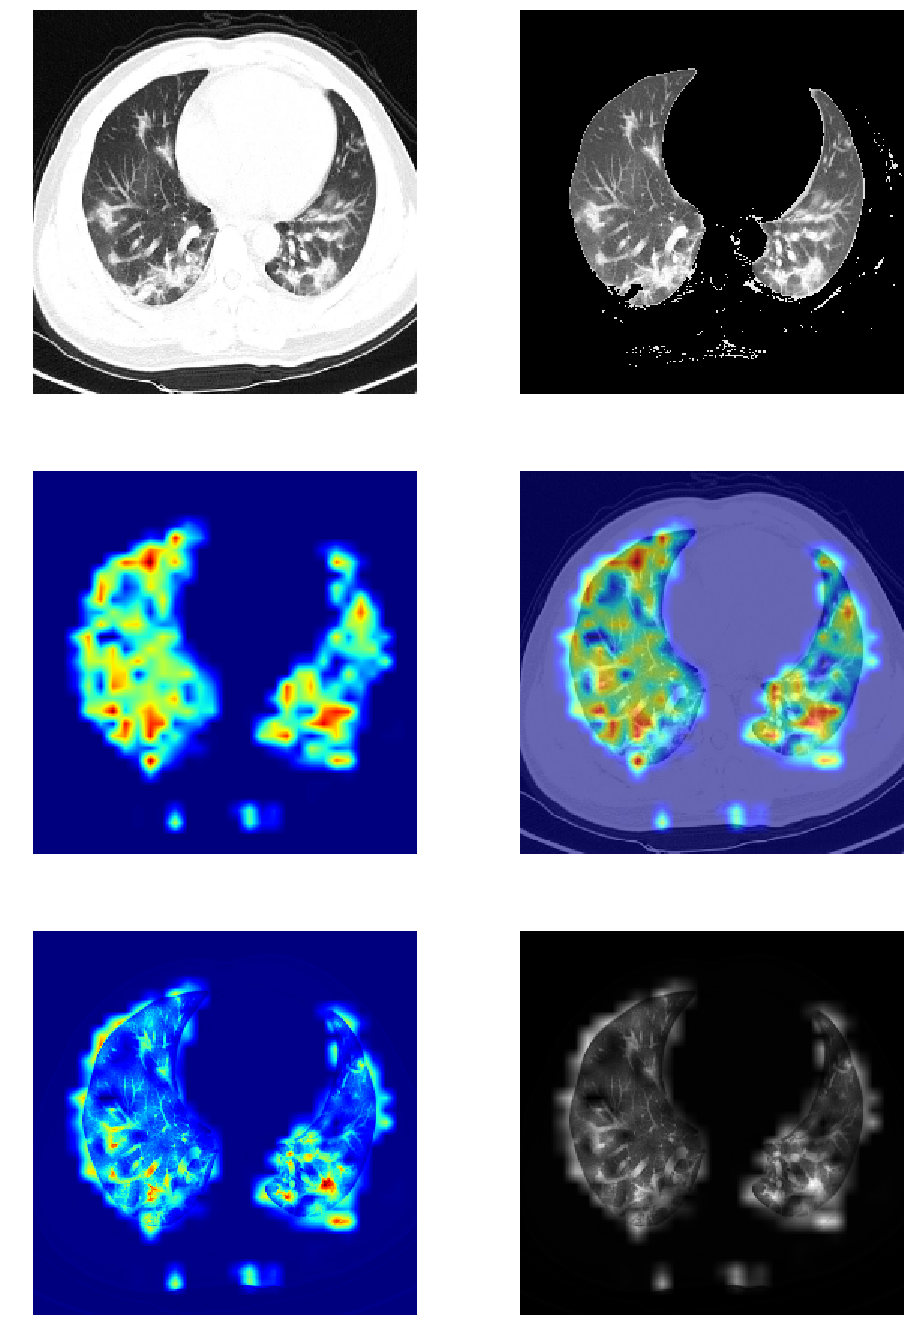

In [6]:
inx = 1

item = trainset.__getitem__(inx)

plt.figure(figsize=(16,24))
plt.subplot(321)
plt.imshow(item['image'].numpy()[0],"gray")
plt.axis('off');

plt.subplot(325)
plt.imshow(item['img'].numpy()[0],"jet")
plt.axis('off');

plt.subplot(326)
plt.imshow(item['img'].numpy()[0],"gray")
plt.axis('off');

plt.subplot(322)
plt.imshow(item['lung'],"gray")
plt.axis('off');

plt.subplot(323)
plt.imshow(item['mp'], 'jet')
plt.axis('off');

plt.subplot(324)
plt.imshow(item['image'].numpy()[0], 'gray')
plt.imshow(item['mp'], 'jet',alpha=0.6)
plt.axis('off')


plt.savefig('{0}/img.png'.format(mypath))

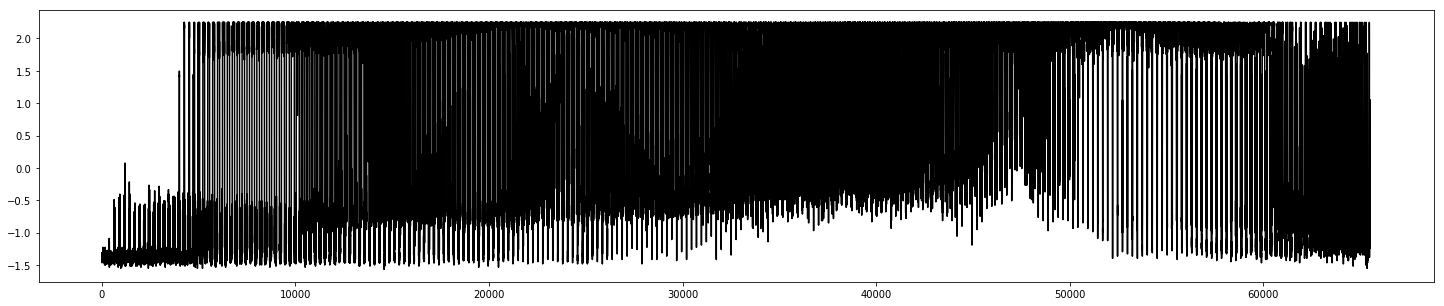

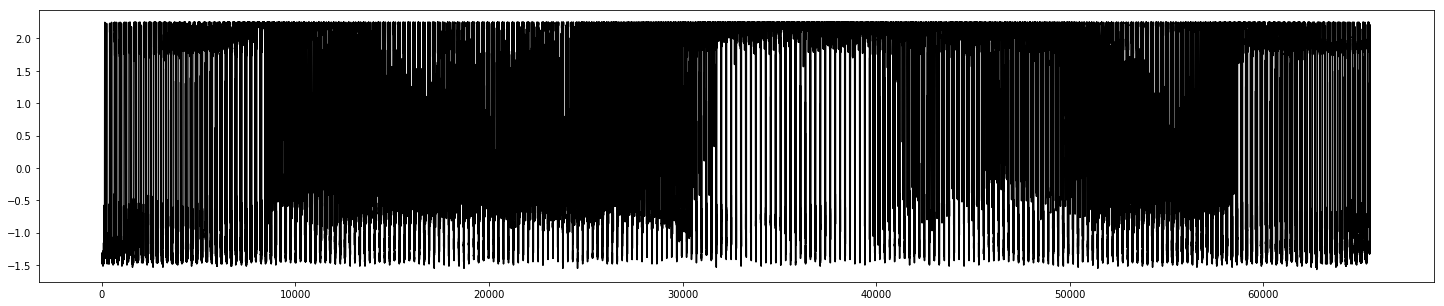

In [4]:
Flat_x_COVID_image = trainset.__getitem__(1)['image'].numpy()[0].flatten()
Flat_y_COVID_image = trainset.__getitem__(1)['image'].numpy()[0].flatten("F")

plt.figure(figsize=(25,5))
plt.plot(range(len(Flat_x_COVID_image)),Flat_x_COVID_image,'k',label="flatten image");
plt.figure(figsize=(25,5))
plt.plot(range(len(Flat_y_COVID_image)),Flat_y_COVID_image,'k',label="flatten image");

In [5]:
window_size = 4096*2
mp1, mpi1 = stomp(Flat_x_COVID_image, window_size)
Profile1 = np.append(mp1, np.zeros(window_size - 1) + np.nan)
ProfileIndex1 = np.append(mpi1, np.zeros(window_size - 1) + np.nan)

mp2, mpi2 = stomp(Flat_y_COVID_image, window_size)
Profile2 = np.append(mp2, np.zeros(window_size - 1) + np.nan)
ProfileIndex2 = np.append(mpi2, np.zeros(window_size - 1) + np.nan)

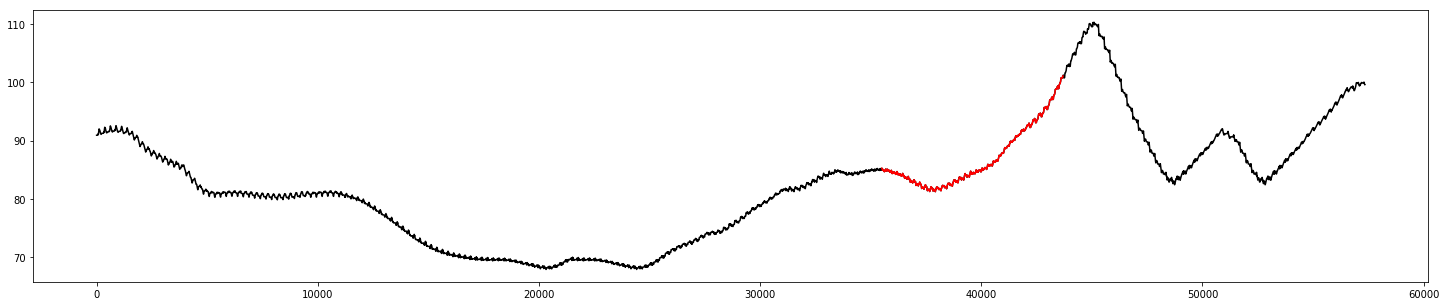

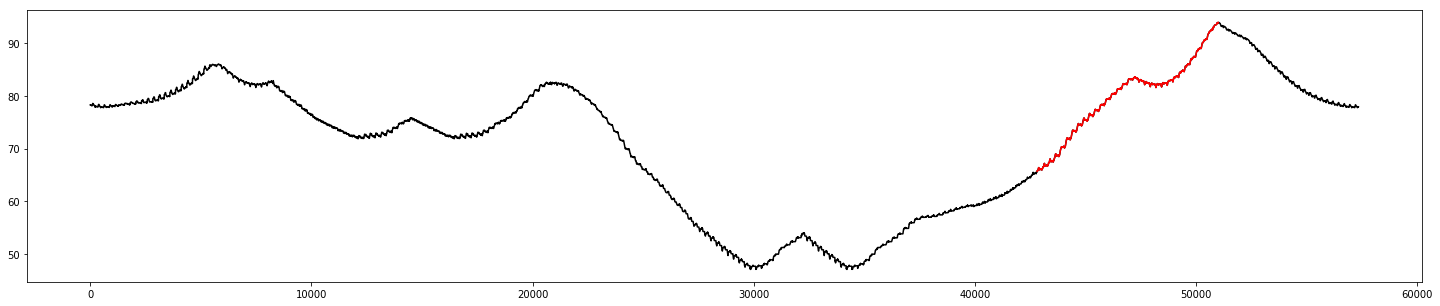

(-0.5, 255.5, 255.5, -0.5)

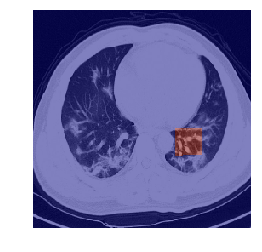

In [6]:
K=4
t=3
top_discords1 =  discords(mp1, window_size, k=K)
plt.figure(figsize=(25,5))
plt.plot(range(len(Profile1)),Profile1,'k',label="flatten image");
discords_index1 = []
for i in top_discords1[t:K]:
    discords_index1.append(np.arange(i,i+window_size))
    plt.plot(range(i,i+window_size),Profile1[i:i+window_size],'r');

discords_index1 = [y for x in discords_index1 for y in x]
plt.show()

top_discords2 =  discords(mp2, window_size, k=K)
plt.figure(figsize=(25,5))
plt.plot(range(len(Profile2)),Profile2,'k',label="flatten image");
discords_index2 = []
for i in top_discords2[t:K]:
    discords_index2.append(np.arange(i,i+window_size))
    plt.plot(range(i,i+window_size),Profile2[i:i+window_size],'r');

discords_index2 = [y for x in discords_index2 for y in x]
plt.show()


dis1 = np.zeros(Flat_x_COVID_image.shape)
dis1[discords_index1]=1
disX = dis1.reshape(256,-1)
dis2 = np.zeros(Flat_y_COVID_image.shape)
dis2[discords_index2]=1
disY = dis2.reshape(256,-1,order='F')
mask = disX+disY
mask[mask!=2] = 0

plt.figure()
plt.imshow(trainset.__getitem__(1)['image'].numpy()[0], 'gray')
plt.imshow(mask, 'jet',alpha=0.5)
plt.axis('off')


In [8]:
# classifier
device = 'cuda'
def train(optimizer, epoch):    
    model.train()   
    train_loss = 0
    train_correct = 0    
    for batch_index, batch_samples in enumerate(train_loader):        
        data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
        data = data[:, 0, :, :]
        data = data[:, None, :, :]    
        optimizer.zero_grad()
        output = model(data)     
        criteria = nn.CrossEntropyLoss()
        loss = criteria(output, target.long())
        train_loss += criteria(output, target.long())        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.long().view_as(pred)).sum().item()    
        # Display progress and write to tensorboard
        if batch_index % bs == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_index, len(train_loader),
                100.0 * batch_index / len(train_loader), loss.item()/ bs))    
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
        100.0 * train_correct / len(train_loader.dataset)))

def val(epoch):    
    model.eval()
    test_loss = 0
    correct = 0
    results = []    
    TP = 0
    TN = 0
    FN = 0
    FP = 0   
    criteria = nn.CrossEntropyLoss()
    with torch.no_grad():
        tpr_list = []
        fpr_list = []        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(val_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
            data = data[:, 0, :, :]
            data = data[:, None, :, :]
            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.long().view_as(pred)).sum().item()
            
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
                    
    return targetlist, scorelist, predlist


def test(epoch):    
    model.eval()
    test_loss = 0
    correct = 0
    results = []   
    TP = 0
    TN = 0
    FN = 0
    FP = 0   
    criteria = nn.CrossEntropyLoss()
    with torch.no_grad():
        tpr_list = []
        fpr_list = []        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(test_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
            data = data[:, 0, :, :]
            data = data[:, None, :, :]
            output = model(data)            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.long().view_as(pred)).sum().item()
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
           
    return targetlist, scorelist, predlist
    
    

class DenseNetModel(nn.Module):

    def __init__(self):
        super(DenseNetModel, self).__init__()

        self.dense_net = xrv.models.DenseNet(num_classes=2)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        logits = self.dense_net(x)
        return logits
    
model = DenseNetModel().cuda()
modelname = 'DenseNet'


In [9]:
# Plot the DenseNet model
print(model)
#x = torch.zeros(10, 1, 224, 224, dtype=torch.float, requires_grad=False)
#x = x.type(torch.cuda.FloatTensor)
#out = model(x)
#make_dot(out)

DenseNetModel(
  (dense_net): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome

In [11]:
# train
bs = 10
votenum = 10

import warnings
warnings.filterwarnings('ignore')

r_list = []
p_list = []
acc_list = []
AUC_list = []

vote_pred = np.zeros(valset.__len__())
vote_score = np.zeros(valset.__len__())

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

total_epoch = 20
for epoch in range(1, total_epoch+1):
    train(optimizer, epoch)    
    targetlist, scorelist, predlist = val(epoch)
    vote_pred = vote_pred + predlist 
    vote_score = vote_score + scorelist 
    if epoch % votenum == 0:        
        # major vote
        vote_pred[vote_pred <= (votenum/2)] = 0
        vote_pred[vote_pred > (votenum/2)] = 1
        vote_score = vote_score/votenum        
        print('vote_pred', vote_pred)
        print('targetlist', targetlist)
        TP = ((vote_pred == 1) & (targetlist == 1)).sum()
        TN = ((vote_pred == 0) & (targetlist == 0)).sum()
        FN = ((vote_pred == 0) & (targetlist == 1)).sum()
        FP = ((vote_pred == 1) & (targetlist == 0)).sum()
                
        print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
        print('TP+FP',TP+FP)
        p = TP / (TP + FP)
        print('precision',p)
        p = TP / (TP + FP)
        r = TP / (TP + FN)
        print('recall',r)
        F1 = 2 * r * p / (r + p)
        acc = (TP + TN) / (TP + TN + FP + FN)
        print('F1',F1)
        print('acc',acc)
        AUC = roc_auc_score(targetlist, vote_score)
        print('AUCp', roc_auc_score(targetlist, vote_pred))
        print('AUC', AUC)
         
        torch.save(model.state_dict(), "model_backup/{}.pt".format(modelname))  
        
        vote_pred = np.zeros(valset.__len__())
        vote_score = np.zeros(valset.__len__())
        print('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))

        f = open('model_result/{}.txt'.format(modelname), 'a+')
        f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))
        f.close()


Train Epoch: 1 [0/43 (0%)]	Train Loss: 0.063452
Train Epoch: 1 [10/43 (23%)]	Train Loss: 0.055246
Train Epoch: 1 [20/43 (47%)]	Train Loss: 0.042348
Train Epoch: 1 [30/43 (70%)]	Train Loss: 0.056757
Train Epoch: 1 [40/43 (93%)]	Train Loss: 0.030722

Train set: Average loss: 0.0483, Accuracy: 340/425 (80%)

Train Epoch: 2 [0/43 (0%)]	Train Loss: 0.045845
Train Epoch: 2 [10/43 (23%)]	Train Loss: 0.056036
Train Epoch: 2 [20/43 (47%)]	Train Loss: 0.039025
Train Epoch: 2 [30/43 (70%)]	Train Loss: 0.026032
Train Epoch: 2 [40/43 (93%)]	Train Loss: 0.043547

Train set: Average loss: 0.0394, Accuracy: 347/425 (82%)

Train Epoch: 3 [0/43 (0%)]	Train Loss: 0.027417
Train Epoch: 3 [10/43 (23%)]	Train Loss: 0.039229
Train Epoch: 3 [20/43 (47%)]	Train Loss: 0.023891
Train Epoch: 3 [30/43 (70%)]	Train Loss: 0.036111
Train Epoch: 3 [40/43 (93%)]	Train Loss: 0.027332

Train set: Average loss: 0.0317, Accuracy: 369/425 (87%)

Train Epoch: 4 [0/43 (0%)]	Train Loss: 0.020252
Train Epoch: 4 [10/43 (23%)]	Tr

In [12]:
# test
bs = 10
import warnings
warnings.filterwarnings('ignore')

r_list = []
p_list = []
acc_list = []
AUC_list = []

vote_pred = np.zeros(testset.__len__())
vote_score = np.zeros(testset.__len__())

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scheduler = StepLR(optimizer, step_size=1)

total_epoch = 10
for epoch in range(1, total_epoch+1):
    
    targetlist, scorelist, predlist = test(epoch)
    vote_pred = vote_pred + predlist 
    vote_score = vote_score + scorelist 
    
    TP = ((predlist == 1) & (targetlist == 1)).sum()
    TN = ((predlist == 0) & (targetlist == 0)).sum()
    FN = ((predlist == 0) & (targetlist == 1)).sum()
    FP = ((predlist == 1) & (targetlist == 0)).sum()

    print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
    print('TP+FP',TP+FP)
    p = TP / (TP + FP)
    print('precision',p)
    p = TP / (TP + FP)
    r = TP / (TP + FN)
    print('recall',r)
    F1 = 2 * r * p / (r + p)
    acc = (TP + TN) / (TP + TN + FP + FN)
    print('F1',F1)
    print('acc',acc)
    AUC = roc_auc_score(targetlist, vote_score)
    print('AUC', AUC)

    if epoch % votenum == 0:
        
        # major vote
        vote_pred[vote_pred <= (votenum/2)] = 0
        vote_pred[vote_pred > (votenum/2)] = 1

        TP = ((vote_pred == 1) & (targetlist == 1)).sum()
        TN = ((vote_pred == 0) & (targetlist == 0)).sum()
        FN = ((vote_pred == 0) & (targetlist == 1)).sum()
        FP = ((vote_pred == 1) & (targetlist == 0)).sum()
        
        print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
        print('TP+FP',TP+FP)
        p = TP / (TP + FP)
        print('precision',p)
        p = TP / (TP + FP)
        r = TP / (TP + FN)
        print('recall',r)
        F1 = 2 * r * p / (r + p)
        acc = (TP + TN) / (TP + TN + FP + FN)
        print('F1',F1)
        print('acc',acc)
        AUC = roc_auc_score(targetlist, vote_score)
        print('AUC', AUC)
         
        vote_pred = np.zeros((1,testset.__len__()))
        vote_score = np.zeros(testset.__len__())
        print('vote_pred',vote_pred)
        print('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))

        f = open(f'model_result/test_{modelname}.txt', 'a+')
        f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))
        f.close()
        

TP= 78 TN= 69 FN= 27 FP= 29
TP+FP 107
precision 0.7289719626168224
recall 0.7428571428571429
F1 0.7358490566037735
acc 0.7241379310344828
AUC 0.7964042759961129
TP= 78 TN= 69 FN= 27 FP= 29
TP+FP 107
precision 0.7289719626168224
recall 0.7428571428571429
F1 0.7358490566037735
acc 0.7241379310344828
AUC 0.7964042759961129
TP= 78 TN= 69 FN= 27 FP= 29
TP+FP 107
precision 0.7289719626168224
recall 0.7428571428571429
F1 0.7358490566037735
acc 0.7241379310344828
AUC 0.7964042759961129
TP= 78 TN= 69 FN= 27 FP= 29
TP+FP 107
precision 0.7289719626168224
recall 0.7428571428571429
F1 0.7358490566037735
acc 0.7241379310344828
AUC 0.7964042759961129
TP= 78 TN= 69 FN= 27 FP= 29
TP+FP 107
precision 0.7289719626168224
recall 0.7428571428571429
F1 0.7358490566037735
acc 0.7241379310344828
AUC 0.7964042759961129
TP= 78 TN= 69 FN= 27 FP= 29
TP+FP 107
precision 0.7289719626168224
recall 0.7428571428571429
F1 0.7358490566037735
acc 0.7241379310344828
AUC 0.7964042759961129
TP= 78 TN= 69 FN= 27 FP= 29
TP+FP 